In [1]:
#@title MIT License
#
# Copyright (c) 2019 Andreas Eberlein
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Train a deep neural network for semantic segmentation based on Virtual KITTI dataset

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.activations as activations
import tensorflow.keras.losses as losses
import tensorflow.keras.metrics as metrics
import tensorflow.keras.utils as utils
import tensorflow.keras.callbacks as callbacks


import cv2
import pickle
import h5py

In [3]:
import data_helper

In [4]:
processed_training_data_file_name = "../Data_compressed/Preprocessed/ProcessedTrainingData.hdf5"

data_file = h5py.File(processed_training_data_file_name, 'r')

one_hot_encoded_labels = data_file['one_hot_encoded_labels']
train_images = data_file['training_images']

In [5]:
# Briefly check whether reimport of data worked out
print(one_hot_encoded_labels.shape)
print(train_images.shape)

(447, 125, 414, 14)
(447, 125, 414, 3)


In [6]:
dict_file_name = '../Data_compressed/Preprocessed/Dictionaries.dat'
dict_file = open(dict_file_name, 'rb')
value_category_id_mappings = pickle.load(dict_file)
dict_file.close()
values_categories_dict, categories_ids_dict, ids_categories_dict, \
            ids_values_dict, values_ids_dict = value_category_id_mappings
print(categories_ids_dict)
print(ids_values_dict)

{'GuardRail': 0, 'Terrain': 1, 'Car': 2, 'Pole': 3, 'Vegetation': 4, 'Truck': 5, 'TrafficSign': 6, 'Sky': 7, 'TrafficLight': 8, 'Misc': 9, 'Van': 10, 'Road': 11, 'Building': 12, 'Tree': 13}
{0: (255, 100, 255), 1: (210, 0, 200), 2: (200, 200, 200), 3: (255, 130, 0), 4: (90, 240, 0), 5: (160, 60, 60), 6: (255, 255, 0), 7: (90, 200, 255), 8: (200, 200, 0), 9: (80, 80, 80), 10: (230, 208, 202), 11: (100, 60, 100), 12: (140, 140, 140), 13: (0, 199, 0)}


In [7]:
# Now we reconstruct a few label images from one-hot encoding to colour coding for testing purposes
decoded_labels = data_helper.oneHotDecodeImages(one_hot_encoded_labels[0:4], ids_values_dict)

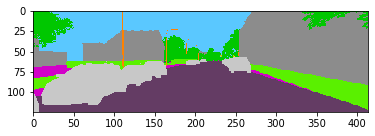

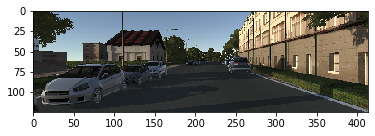

In [8]:
data_helper.plot_as_rgb_image(decoded_labels[0])
plt.show()
data_helper.plot_as_rgb_image(train_images[0])
plt.show()

## Setting model and training parameters

In [9]:
batch_size = 8
epochs = 150
img_shape = train_images[0].shape
img_shape

(125, 414, 3)

## Define model
The stated results for quality metrics are for `batch_size = 8`, `epochs = 50`, `160` training images and a fixed learning rate of `0.0001`.

W0716 20:16:27.170110 139952991921984 deprecation.py:506] From /home/andreas/Programmieren_MachineLearning/anaconda3/envs/VirtualKITTI/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


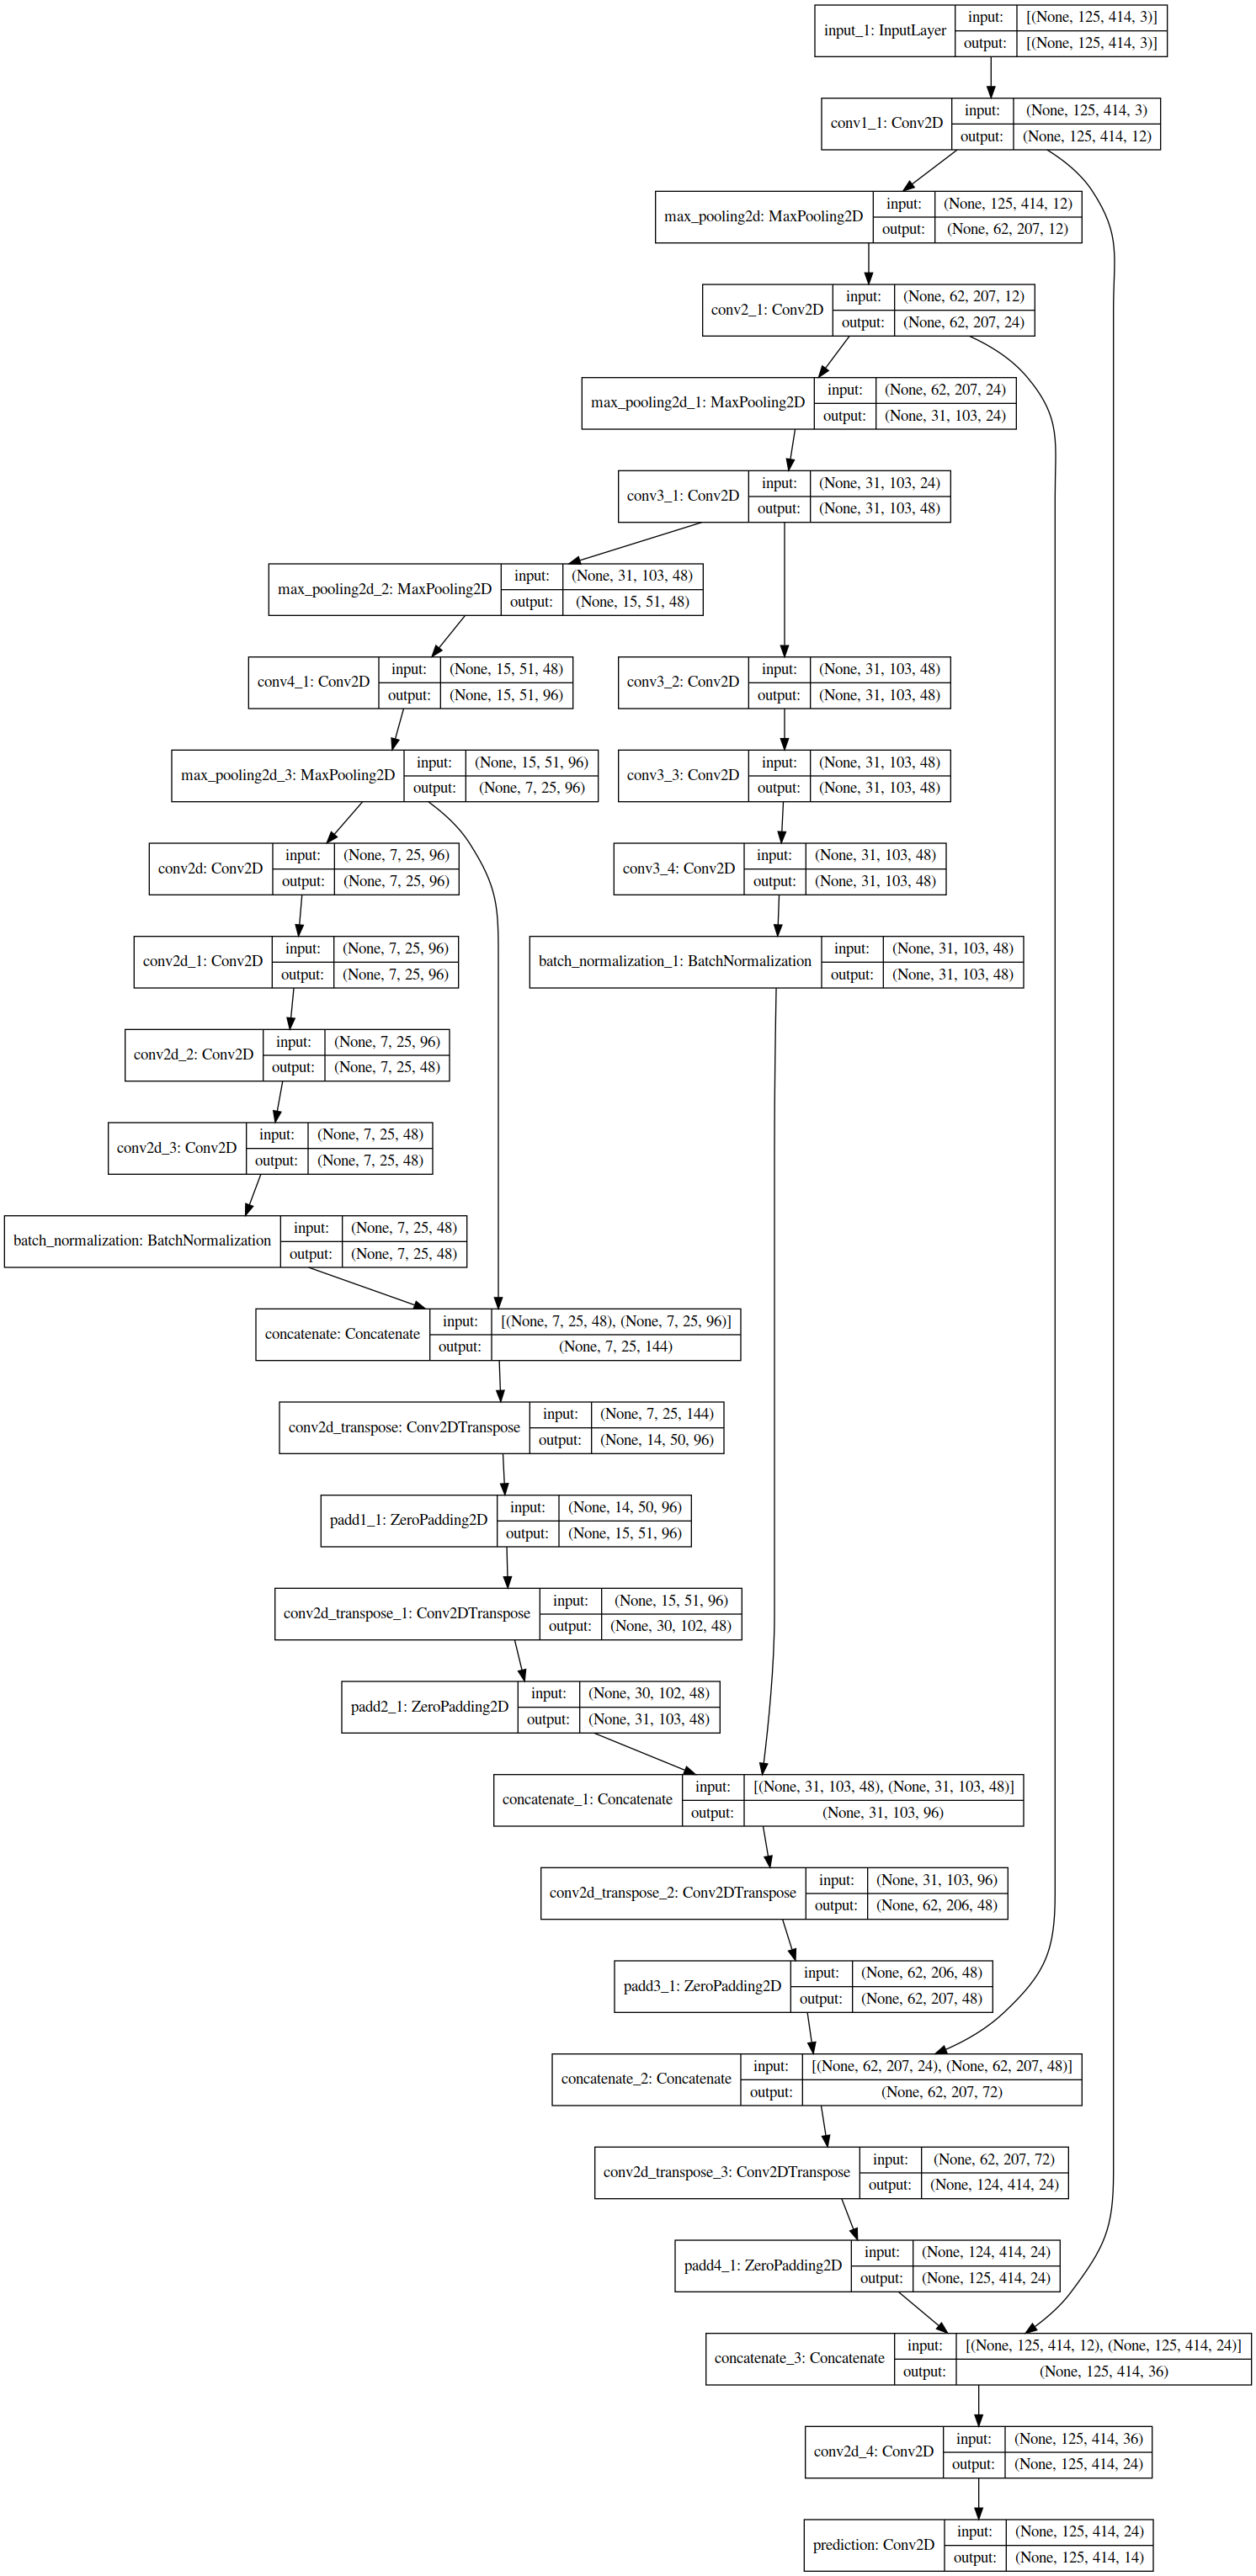

In [10]:
def bottleneckWithSkipLayerModel():
    #           loss         acc   mean_io_u    val_loss     val_acc    val_mean_io_u
    # 49    0.056245    0.612250    0.562411    0.058371    0.598306    0.552687    Trained with 160 images
    # 49    0.069816    0.512127    0.563289    0.071772    0.498191    0.565212    Trained with 320 images
    inputs = layers.Input(shape=img_shape)
    conv1 = layers.Conv2D(12, 3, padding='same', activation='relu')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(24, 3, padding='same', activation='relu')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(48, 3, padding='same', activation='relu')(pool2)
    upsampl1 = layers.UpSampling2D(size=(2,2))(conv3)
    padd1 = layers.ZeroPadding2D(padding=((0,0), (0,1)))(upsampl1)
    conv4 = layers.Conv2D(24, 3, padding='same', activation='relu')(padd1)
    concat1 = layers.concatenate([conv2, conv4], axis=-1)
    conv5 = layers.Conv2D(48, 3, padding='same', activation='relu')(concat1)
    upsampl2 = layers.UpSampling2D(size=(2,2))(conv5)
    padd2 = layers.ZeroPadding2D(padding=((1,0), (0,0)))(upsampl2)
    conv6 = layers.Conv2D(24, 3, padding='same', activation='relu')(padd2)
    predictions = layers.Conv2D(one_hot_encoded_labels.shape[3], 3, padding='same', 
                                activation=activations.softmax)(conv6)
        
    return models.Model(inputs=inputs, outputs=predictions)

def bottleneckModelWithSkipLayers():
    #           loss         acc   mean_io_u    val_loss     val_acc    val_mean_io_u
    # 49    0.060510    0.579252    0.612366    0.067015    0.533291    0.588853    Trained with 160 images
    inputs = layers.Input(shape=img_shape)
    conv1 = layers.Conv2D(12, 3, padding='same', activation='relu')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(24, 3, padding='same', activation='relu')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(48, 3, padding='same', activation='relu')(pool2)
    upsampl1 = layers.UpSampling2D(size=(2,2))(conv3)
    padd1 = layers.ZeroPadding2D(padding=((0,0), (0,1)))(upsampl1)
    conv4 = layers.Conv2D(24, 3, padding='same', activation='relu')(padd1)
    concat1 = layers.Concatenate(axis=-1)([conv2, conv4])
    conv5 = layers.Conv2D(48, 3, padding='same', activation='relu')(concat1)
    upsampl2 = layers.UpSampling2D(size=(2,2))(conv5)
    padd2 = layers.ZeroPadding2D(padding=((1,0), (0,0)))(upsampl2)
    conv6 = layers.Conv2D(24, 3, padding='same', activation='relu')(padd2)
    concat2 = layers.Concatenate(axis=-1)([conv1, conv6])
    conv7 = layers.Conv2D(24, 5, padding='same', activation='relu')(concat2)
    predictions = layers.Conv2D(one_hot_encoded_labels.shape[3], 3, padding='same', 
                                activation=activations.softmax)(conv7)
        
    return models.Model(inputs=inputs, outputs=predictions)

def multiBranchWithSkipLayers():
    #           loss         acc   mean_io_u    val_loss     val_acc    val_mean_io_u
    # 49    0.088776    0.381538    0.528579    0.091028    0.364687    0.535280    Trained with 160 images
    # 49    0.062288    0.564909    0.654598    0.061894    0.567607    0.659338    Trained with 320 images
    # 99    0.060168    0.579116    0.687793    0.060103    0.579575    0.693281
    # 299   0.052240    0.634442    0.715232    0.053786    0.623570    0.709052    Trained with 447 images and lr schedule
    #    Observations:
    #        - Almost no improvements after 150 epochs
    #        - Sometimes fine details are resolved, sometimes even larger structures are missed
    #        - Vegetation, sky and vehicles are resolved quite well, while the class for street is always missed
    # Architecture inspired by U-net and Fast-SCNN (1902.04502)
    inputs = layers.Input(shape=img_shape)
    # Encoder part
    conv1_1 = layers.Conv2D(12, 3, padding='same', activation='relu', name='conv1_1')(inputs)
    pool1_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1_1)
    conv2_1 = layers.Conv2D(24, 3, padding='same', activation='relu', name='conv2_1')(pool1_1)
    pool2_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv2_1)
    conv3_1 = layers.Conv2D(48, 3, padding='same', activation='relu', name='conv3_1')(pool2_1)
    pool3_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv3_1)
    conv4_1 = layers.Conv2D(96, 3, padding='same', activation='relu', name='conv4_1')(pool3_1)
    pool4_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv4_1)
    
    # Bottleneck layers for deep part
    conv5_1 = layers.Conv2D(96, 1, padding='same', activation='relu')(pool4_1)
    conv6_1 = layers.Conv2D(96, 3, padding='same', activation='relu')(conv5_1)
    conv7_1 = layers.Conv2D(48, 3, padding='same', activation='relu')(conv6_1)
    conv8_1 = layers.Conv2D(48, 1, padding='same', activation='relu')(conv7_1)
    bottleneck_output = layers.BatchNormalization()(conv8_1)
    
    # Convolutional layers for "intermediate part"
    conv3_2 = layers.Conv2D(48, 3, padding='same', activation='relu', name='conv3_2')(conv3_1)
    conv3_3 = layers.Conv2D(48, 1, padding='same', activation='relu', name='conv3_3')(conv3_2)
    conv3_4 = layers.Conv2D(48, 3, padding='same', activation='relu', name='conv3_4')(conv3_3)
    conv3_4_norm = layers.BatchNormalization()(conv3_4)
    
    # Decoder part
    concat0_1 = layers.Concatenate()([bottleneck_output, pool4_1])
    deconv1_1 = layers.Conv2DTranspose(96, 3, strides=(2,2), padding='same',
                                       activation='relu')(concat0_1)
    padd1_1 = layers.ZeroPadding2D(padding=((0,1), (0,1)), name='padd1_1')(deconv1_1)
    deconv2_1 = layers.Conv2DTranspose(48, 3, strides=(2,2), padding='same',
                                       activation='relu')(padd1_1)
    padd2_1 = layers.ZeroPadding2D(padding=((0,1), (0,1)), name='padd2_1')(deconv2_1)
    concat1_1 = layers.Concatenate()([conv3_4_norm, padd2_1])
    deconv3_1 = layers.Conv2DTranspose(48, 3, strides=(2,2), padding='same',
                                       activation='relu')(concat1_1)
    padd3_1 = layers.ZeroPadding2D(padding=((0,0), (0,1)), name='padd3_1')(deconv3_1)
    concat2_1 = layers.Concatenate()([conv2_1, padd3_1])
    deconv4_1 = layers.Conv2DTranspose(24, 3, strides=(2,2), padding='same',
                                       activation='relu')(concat2_1)
    padd4_1 = layers.ZeroPadding2D(padding=((0,1), (0,0)), name='padd4_1')(deconv4_1)
    concat3_1 = layers.Concatenate()([conv1_1, padd4_1])
    deconv5_1 = layers.Conv2D(24, 3, padding='same', activation='relu')(concat3_1)
    
    predictions = layers.Conv2D(one_hot_encoded_labels.shape[3], 3, padding='same', 
                                activation=activations.softmax, name='prediction')(deconv5_1)
    
    # Ideas for optimization:
    # - Introduce DepthwiseConv2d instead of Conv2d on encoder path
    # - Use upsampling for very heavy Conv2DTranspose layers
    # - Conveniently cut images so that zero padding is unnecessary
    # - Introduce batch normalization on every branch that is merged via concatenation
    # - Use more images during training!
    
    return models.Model(inputs=inputs, outputs=predictions)

model = multiBranchWithSkipLayers()
utils.plot_model(model, to_file='model.png', show_shapes=True)

In [11]:
optimizer = tf.keras.optimizers.RMSprop()

model.compile(optimizer=optimizer,
              loss=losses.mean_absolute_error, # Try other loss, for example crossentropy
              metrics=['accuracy', metrics.MeanIoU(num_classes=one_hot_encoded_labels.shape[3])]
             )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 125, 414, 3) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 125, 414, 12) 336         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 62, 207, 12)  0           conv1_1[0][0]                    
__________________________________________________________________________________________________
conv2_1 (Conv2D)                (None, 62, 207, 24)  2616        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [12]:
def learning_rate_schedule(epoch):
    return 0.001 / 3**(epoch // 50)

lr_schedule = callbacks.LearningRateScheduler(learning_rate_schedule, verbose=1)

history = model.fit(train_images[0:], one_hot_encoded_labels[0:], epochs=epochs,
                   validation_split=0.15, verbose=1, initial_epoch=0, callbacks=[lr_schedule])

Train on 379 samples, validate on 68 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/300
379/379 [==============================] - 834s 2s/sample - loss: 0.1213 - acc: 0.1508 - mean_io_u: 0.4936 - val_loss: 0.0981 - val_acc: 0.3140 - val_mean_io_u: 0.5524

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/300
379/379 [==============================] - 121s 318ms/sample - loss: 0.0960 - acc: 0.3280 - mean_io_u: 0.5624 - val_loss: 0.0965 - val_acc: 0.3260 - val_mean_io_u: 0.5401

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/300
379/379 [==============================] - 85s 223ms/sample - loss: 0.0950 - acc: 0.3350 - mean_io_u: 0.5706 - val_loss: 0.0962 - val_acc: 0.3266 - val_mean_io_u: 0.5962

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/300
379/379 [==============================] - 85s 224ms/sample - loss: 0.0942 - acc: 0.3402 - mean_io_u: 0.5851 - val_loss: 0

379/379 [==============================] - 85s 224ms/sample - loss: 0.0549 - acc: 0.6159 - mean_io_u: 0.6925 - val_loss: 0.0561 - val_acc: 0.6076 - val_mean_io_u: 0.6855

Epoch 00034: LearningRateScheduler reducing learning rate to 0.001.
Epoch 34/300
379/379 [==============================] - 87s 231ms/sample - loss: 0.0543 - acc: 0.6198 - mean_io_u: 0.6966 - val_loss: 0.0565 - val_acc: 0.6045 - val_mean_io_u: 0.6861

Epoch 00035: LearningRateScheduler reducing learning rate to 0.001.
Epoch 35/300
379/379 [==============================] - 85s 225ms/sample - loss: 0.0548 - acc: 0.6163 - mean_io_u: 0.6935 - val_loss: 0.0559 - val_acc: 0.6092 - val_mean_io_u: 0.6866

Epoch 00036: LearningRateScheduler reducing learning rate to 0.001.
Epoch 36/300
379/379 [==============================] - 85s 224ms/sample - loss: 0.0544 - acc: 0.6196 - mean_io_u: 0.6975 - val_loss: 0.0559 - val_acc: 0.6087 - val_mean_io_u: 0.6879

Epoch 00037: LearningRateScheduler reducing learning rate to 0.001.
Epoch


Epoch 00065: LearningRateScheduler reducing learning rate to 0.0003333333333333333.
Epoch 65/300
379/379 [==============================] - 86s 226ms/sample - loss: 0.0529 - acc: 0.6301 - mean_io_u: 0.7148 - val_loss: 0.0543 - val_acc: 0.6202 - val_mean_io_u: 0.7027

Epoch 00066: LearningRateScheduler reducing learning rate to 0.0003333333333333333.
Epoch 66/300
379/379 [==============================] - 86s 226ms/sample - loss: 0.0528 - acc: 0.6304 - mean_io_u: 0.7133 - val_loss: 0.0543 - val_acc: 0.6202 - val_mean_io_u: 0.7042

Epoch 00067: LearningRateScheduler reducing learning rate to 0.0003333333333333333.
Epoch 67/300
379/379 [==============================] - 86s 226ms/sample - loss: 0.0528 - acc: 0.6302 - mean_io_u: 0.7129 - val_loss: 0.0543 - val_acc: 0.6198 - val_mean_io_u: 0.7031

Epoch 00068: LearningRateScheduler reducing learning rate to 0.0003333333333333333.
Epoch 68/300
379/379 [==============================] - 86s 227ms/sample - loss: 0.0528 - acc: 0.6308 - mean_io

379/379 [==============================] - 84s 221ms/sample - loss: 0.0526 - acc: 0.6321 - mean_io_u: 0.7158 - val_loss: 0.0540 - val_acc: 0.6221 - val_mean_io_u: 0.7112

Epoch 00096: LearningRateScheduler reducing learning rate to 0.0003333333333333333.
Epoch 96/300
379/379 [==============================] - 82s 216ms/sample - loss: 0.0526 - acc: 0.6320 - mean_io_u: 0.7153 - val_loss: 0.0539 - val_acc: 0.6226 - val_mean_io_u: 0.7069

Epoch 00097: LearningRateScheduler reducing learning rate to 0.0003333333333333333.
Epoch 97/300
379/379 [==============================] - 82s 216ms/sample - loss: 0.0526 - acc: 0.6321 - mean_io_u: 0.7149 - val_loss: 0.0539 - val_acc: 0.6224 - val_mean_io_u: 0.7116

Epoch 00098: LearningRateScheduler reducing learning rate to 0.0003333333333333333.
Epoch 98/300
379/379 [==============================] - 82s 216ms/sample - loss: 0.0525 - acc: 0.6324 - mean_io_u: 0.7155 - val_loss: 0.0540 - val_acc: 0.6223 - val_mean_io_u: 0.7083

Epoch 00099: LearningRate


Epoch 00126: LearningRateScheduler reducing learning rate to 0.00011111111111111112.
Epoch 126/300
379/379 [==============================] - 82s 218ms/sample - loss: 0.0524 - acc: 0.6334 - mean_io_u: 0.7160 - val_loss: 0.0538 - val_acc: 0.6231 - val_mean_io_u: 0.7089

Epoch 00127: LearningRateScheduler reducing learning rate to 0.00011111111111111112.
Epoch 127/300
379/379 [==============================] - 85s 223ms/sample - loss: 0.0524 - acc: 0.6335 - mean_io_u: 0.7153 - val_loss: 0.0538 - val_acc: 0.6232 - val_mean_io_u: 0.7085

Epoch 00128: LearningRateScheduler reducing learning rate to 0.00011111111111111112.
Epoch 128/300
379/379 [==============================] - 82s 216ms/sample - loss: 0.0524 - acc: 0.6336 - mean_io_u: 0.7153 - val_loss: 0.0538 - val_acc: 0.6232 - val_mean_io_u: 0.7104

Epoch 00129: LearningRateScheduler reducing learning rate to 0.00011111111111111112.
Epoch 129/300
379/379 [==============================] - 82s 216ms/sample - loss: 0.0524 - acc: 0.6336 -

379/379 [==============================] - 144s 380ms/sample - loss: 0.0523 - acc: 0.6340 - mean_io_u: 0.7157 - val_loss: 0.0538 - val_acc: 0.6233 - val_mean_io_u: 0.7089

Epoch 00157: LearningRateScheduler reducing learning rate to 3.7037037037037037e-05.
Epoch 157/300
379/379 [==============================] - 87s 229ms/sample - loss: 0.0523 - acc: 0.6340 - mean_io_u: 0.7157 - val_loss: 0.0538 - val_acc: 0.6233 - val_mean_io_u: 0.7092

Epoch 00158: LearningRateScheduler reducing learning rate to 3.7037037037037037e-05.
Epoch 158/300
379/379 [==============================] - 82s 216ms/sample - loss: 0.0523 - acc: 0.6340 - mean_io_u: 0.7158 - val_loss: 0.0538 - val_acc: 0.6234 - val_mean_io_u: 0.7095

Epoch 00159: LearningRateScheduler reducing learning rate to 3.7037037037037037e-05.
Epoch 159/300
379/379 [==============================] - 82s 216ms/sample - loss: 0.0523 - acc: 0.6340 - mean_io_u: 0.7157 - val_loss: 0.0538 - val_acc: 0.6234 - val_mean_io_u: 0.7094

Epoch 00160: Learn

379/379 [==============================] - 83s 219ms/sample - loss: 0.0523 - acc: 0.6342 - mean_io_u: 0.7153 - val_loss: 0.0538 - val_acc: 0.6235 - val_mean_io_u: 0.7098

Epoch 00187: LearningRateScheduler reducing learning rate to 3.7037037037037037e-05.
Epoch 187/300
379/379 [==============================] - 82s 217ms/sample - loss: 0.0523 - acc: 0.6342 - mean_io_u: 0.7154 - val_loss: 0.0538 - val_acc: 0.6234 - val_mean_io_u: 0.7085

Epoch 00188: LearningRateScheduler reducing learning rate to 3.7037037037037037e-05.
Epoch 188/300
379/379 [==============================] - 83s 218ms/sample - loss: 0.0523 - acc: 0.6342 - mean_io_u: 0.7154 - val_loss: 0.0538 - val_acc: 0.6234 - val_mean_io_u: 0.7086

Epoch 00189: LearningRateScheduler reducing learning rate to 3.7037037037037037e-05.
Epoch 189/300
379/379 [==============================] - 82s 218ms/sample - loss: 0.0523 - acc: 0.6342 - mean_io_u: 0.7151 - val_loss: 0.0538 - val_acc: 0.6235 - val_mean_io_u: 0.7094

Epoch 00190: Learni


Epoch 00217: LearningRateScheduler reducing learning rate to 1.234567901234568e-05.
Epoch 217/300
379/379 [==============================] - 97s 257ms/sample - loss: 0.0523 - acc: 0.6343 - mean_io_u: 0.7153 - val_loss: 0.0538 - val_acc: 0.6235 - val_mean_io_u: 0.7093

Epoch 00218: LearningRateScheduler reducing learning rate to 1.234567901234568e-05.
Epoch 218/300
379/379 [==============================] - 84s 221ms/sample - loss: 0.0523 - acc: 0.6343 - mean_io_u: 0.7154 - val_loss: 0.0538 - val_acc: 0.6235 - val_mean_io_u: 0.7089

Epoch 00219: LearningRateScheduler reducing learning rate to 1.234567901234568e-05.
Epoch 219/300
379/379 [==============================] - 84s 222ms/sample - loss: 0.0523 - acc: 0.6344 - mean_io_u: 0.7152 - val_loss: 0.0538 - val_acc: 0.6235 - val_mean_io_u: 0.7095

Epoch 00220: LearningRateScheduler reducing learning rate to 1.234567901234568e-05.
Epoch 220/300
379/379 [==============================] - 83s 219ms/sample - loss: 0.0523 - acc: 0.6343 - mea

379/379 [==============================] - 83s 218ms/sample - loss: 0.0522 - acc: 0.6344 - mean_io_u: 0.7151 - val_loss: 0.0538 - val_acc: 0.6235 - val_mean_io_u: 0.7095

Epoch 00248: LearningRateScheduler reducing learning rate to 1.234567901234568e-05.
Epoch 248/300
379/379 [==============================] - 82s 217ms/sample - loss: 0.0522 - acc: 0.6344 - mean_io_u: 0.7152 - val_loss: 0.0538 - val_acc: 0.6236 - val_mean_io_u: 0.7091

Epoch 00249: LearningRateScheduler reducing learning rate to 1.234567901234568e-05.
Epoch 249/300
379/379 [==============================] - 83s 218ms/sample - loss: 0.0522 - acc: 0.6344 - mean_io_u: 0.7152 - val_loss: 0.0538 - val_acc: 0.6236 - val_mean_io_u: 0.7095

Epoch 00250: LearningRateScheduler reducing learning rate to 1.234567901234568e-05.
Epoch 250/300
379/379 [==============================] - 83s 219ms/sample - loss: 0.0522 - acc: 0.6344 - mean_io_u: 0.7154 - val_loss: 0.0538 - val_acc: 0.6235 - val_mean_io_u: 0.7086

Epoch 00251: LearningR


Epoch 00278: LearningRateScheduler reducing learning rate to 4.11522633744856e-06.
Epoch 278/300
379/379 [==============================] - 83s 218ms/sample - loss: 0.0522 - acc: 0.6344 - mean_io_u: 0.7150 - val_loss: 0.0538 - val_acc: 0.6236 - val_mean_io_u: 0.7090

Epoch 00279: LearningRateScheduler reducing learning rate to 4.11522633744856e-06.
Epoch 279/300
379/379 [==============================] - 83s 218ms/sample - loss: 0.0522 - acc: 0.6344 - mean_io_u: 0.7151 - val_loss: 0.0538 - val_acc: 0.6236 - val_mean_io_u: 0.7092

Epoch 00280: LearningRateScheduler reducing learning rate to 4.11522633744856e-06.
Epoch 280/300
379/379 [==============================] - 83s 218ms/sample - loss: 0.0522 - acc: 0.6344 - mean_io_u: 0.7152 - val_loss: 0.0538 - val_acc: 0.6236 - val_mean_io_u: 0.7090

Epoch 00281: LearningRateScheduler reducing learning rate to 4.11522633744856e-06.
Epoch 281/300
379/379 [==============================] - 83s 218ms/sample - loss: 0.0522 - acc: 0.6344 - mean_io

In [31]:
import pandas as pd
hist = pd.DataFrame(history.history)
hist

,loss,acc,mean_io_u,val_loss,val_acc,val_mean_io_u,lr
0,0.121297,0.150769,0.493633,0.098135,0.313988,0.552405,0.001000
1,0.096049,0.328020,0.562442,0.096536,0.326043,0.540051,0.001000
2,0.095033,0.334991,0.570649,0.096190,0.326561,0.596201,0.001000
3,0.094227,0.340200,0.585104,0.094281,0.339804,0.574019,0.001000
4,0.090713,0.365837,0.569701,0.088970,0.377845,0.562131,0.001000
5,0.086395,0.395587,0.587762,0.084934,0.405753,0.600257,0.001000
6,0.082522,0.422684,0.590843,0.083692,0.414281,0.597953,0.001000
7,0.081176,0.432564,0.589424,0.073073,0.488739,0.619720,0.001000
8,0.069927,0.511249,0.630431,0.068816,0.519353,0.614230,0.001000
9,0.067764,0.526381,0.631966,0.075872,0.469398,0.592462,0.001000


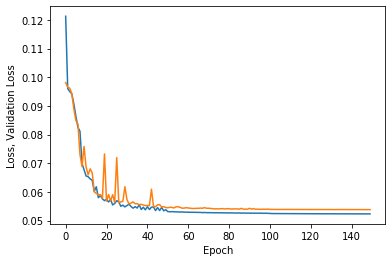

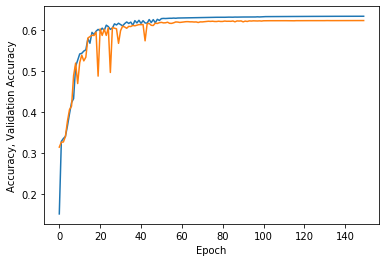

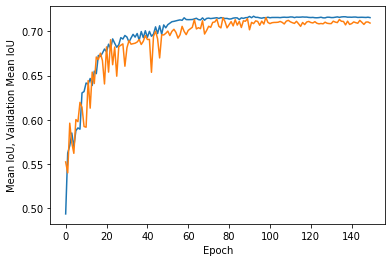

In [28]:
start = 0
end = 150
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss, Validation Loss')
plt.plot(hist['loss'][start:end], label='Loss')
plt.plot(hist['val_loss'][start:end], label='Val Loss')

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy, Validation Accuracy')
plt.plot(hist['acc'][start:end], label='Acc')
plt.plot(hist['val_acc'][start:end], label='Val Acc')

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean IoU, Validation Mean IoU')
plt.plot(hist['mean_io_u'][start:end], label='Mean IoU')
plt.plot(hist['val_mean_io_u'][start:end], label='Val Mean IoU')

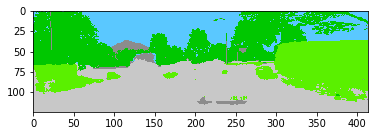

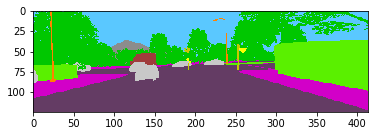

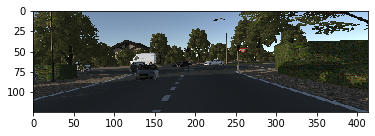

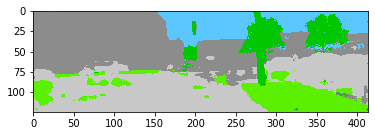

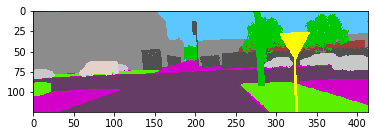

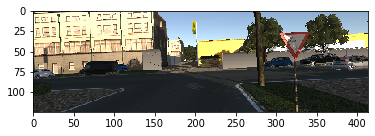

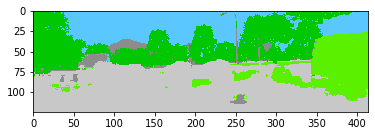

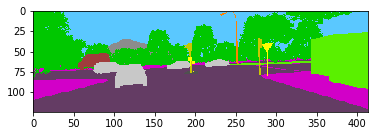

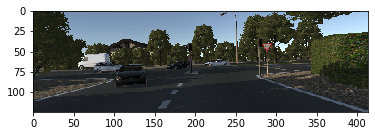

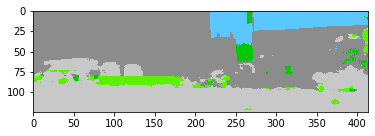

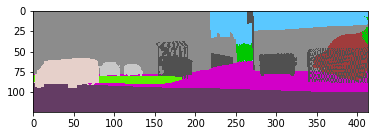

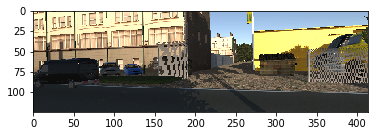

In [35]:
test_prediction = model.predict(train_images[-4:])
test_prediction_decoded = data_helper.oneHotDecodeImages(test_prediction, ids_values_dict)
ground_truth_decoded = data_helper.oneHotDecodeImages(one_hot_encoded_labels[-4:], ids_values_dict)

# Plot a few images for visualizing the results:
# 1) Output of network for semantic segmentation
# 2) Ground truth
# 3) RGB image
for idx in range(-4, 0, 1):
    data_helper.plot_as_rgb_image(test_prediction_decoded[idx])
    plt.show()
    data_helper.plot_as_rgb_image(ground_truth_decoded[idx])
    plt.show()
    data_helper.plot_as_rgb_image(train_images[idx])
    plt.show()
    print()

In [ ]:
data_file.close()

## To do:

- Find better loss function?
- Find more useful quality metrics?